# 1. d2l chapter 3
- Read https://d2l.ai/chapter_linear-regression/index.html and follow along with the code examples.

# 2. Ohm's Law

Imagine that you're a young physicist, maybe named [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm), trying to figure out how current and voltage depend on each other for resistors. You have some idea but you aren't quite sure yet whether the dependence is linear or quadratic. So you take some measurements, conveniently given to you as 'ndarrays' in Python. They are indicated by 'current' and 'voltage'.

Your goal is to use least mean squares regression to identify the coefficients for the following three models using automatic differentiation and least mean squares regression. The three models are:

1. Quadratic model where $\mathrm{voltage} = c + r \cdot \mathrm{current} + q \cdot \mathrm{current}^2$.
1. Linear model where $\mathrm{voltage} = c + r \cdot \mathrm{current}$.
1. Ohm's law where $\mathrm{voltage} = r \cdot \mathrm{current}$.

In [145]:
import torch
current = torch.tensor([1.5420291, 1.8935232, 2.1603365, 2.5381863, 2.893443, \
                    3.838855, 3.925425, 4.2233696, 4.235571, 4.273397, \
                    4.9332876, 6.4704757, 6.517571, 6.87826, 7.0009003, \
                    7.035741, 7.278681, 7.7561755, 9.121138, 9.728281])
voltage = torch.tensor([63.802246, 80.036026, 91.4903, 108.28776, 122.781975, \
                    161.36314, 166.50816, 176.16772, 180.29395, 179.09758, \
                    206.21027, 272.71857, 272.24033, 289.54745, 293.8488, \
                    295.2281, 306.62274, 327.93243, 383.16296, 408.65967])

## 2.1 Answer

In [146]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

In [147]:
current.shape, voltage.shape

(torch.Size([20]), torch.Size([20]))

In [148]:
len(current), len(voltage)

(20, 20)

In [284]:
def plot_predictions(train_data = current,
                     train_labels = voltage,
                     predictions = None):
  '''
  Plots training data, test data and compares predictions.
  '''
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(train_data, predictions, c = "r", s = 4, label = "Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

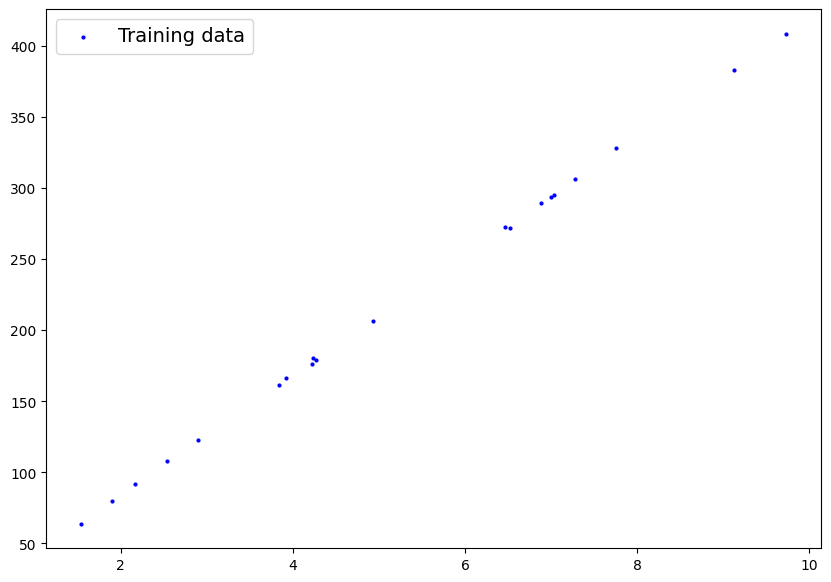

In [150]:
plot_predictions();

### 2.1.1 Quadratic Model

In [151]:
### To prevent exploding Loss
current_normalized = current / current.max()
voltage_normalized = voltage / voltage.max()

### To recover
# y = voltage_max * (c + r * (current / current_max) + q * (current / current_max)^2)
# original_c = voltage_max * c
# original_r = voltage_max * r / current_max
# original_q = voltage_max * q / (current_max ** 2)

In [152]:
from torch import nn

class QuadraticModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initalize model parameter
    self.c = nn.Parameter(torch.randn(1,
                                      requires_grad=True,
                                      dtype=torch.float))
    self.r = nn.Parameter(torch.randn(1,
                                      requires_grad=True,
                                      dtype=torch.float))
    self.q = nn.Parameter(torch.randn(1,
                                      requires_grad=True,
                                      dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.c + self.r * x + self.q * x**2

In [153]:
# Create an instance of the model
model_Quadratic = QuadraticModel()

list(model_Quadratic.parameters())

[Parameter containing:
 tensor([-0.6056], requires_grad=True),
 Parameter containing:
 tensor([1.3903], requires_grad=True),
 Parameter containing:
 tensor([1.4674], requires_grad=True)]

In [154]:
with torch.inference_mode():
  y_preds = model_Quadratic(current)

y_preds

tensor([  5.0276,   7.2883,   9.2464,  12.3769,  15.7023,  26.3564,  27.4631,
         31.4400,  31.6085,  32.1333,  41.9658,  69.8261,  70.7891,  78.3807,
         81.0489,  81.8150,  87.2557,  98.4541, 134.1561, 151.7935])

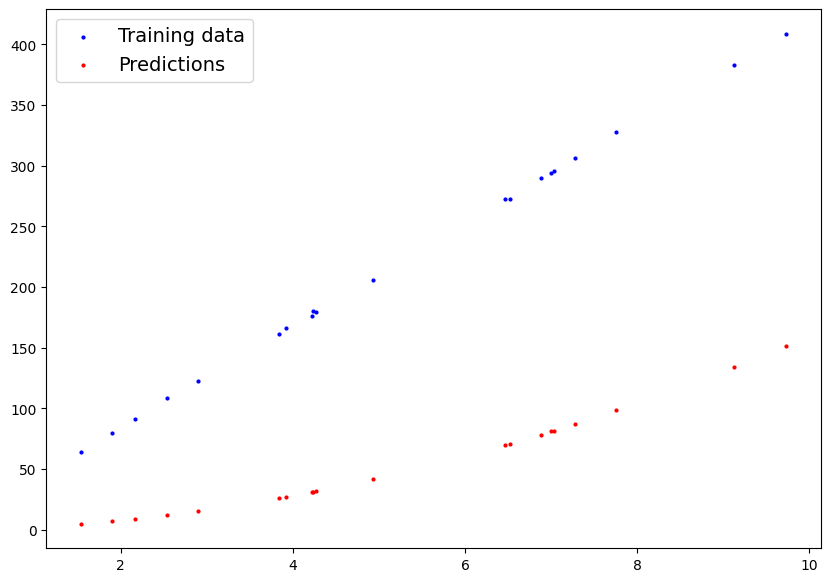

In [155]:
plot_predictions(predictions = y_preds)

In [156]:
# Setup a loss function
loss_fn = nn.MSELoss()

# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_Quadratic.parameters(),
                            lr = 0.001)

In [157]:
epochs = 200

epoch_count = []
loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training model
  model_Quadratic.train()

  #1. Forward pass
  y_pred = model_Quadratic(current_normalized)

  #2. Calculate the loss
  loss = loss_fn(y_pred, voltage_normalized)
  print(f"Loss: {loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5. Step the optimizer
  optimizer.step()

  ### Testing
  model_Quadratic.eval()

  # Print out what's happenin
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    print(f"Epoch: {epoch} | Loss: {loss}")

Loss: 0.2609366774559021
Epoch: 0 | Loss: 0.2609366774559021
Loss: 0.26063650846481323
Loss: 0.2603376805782318
Loss: 0.26004016399383545
Loss: 0.2597438395023346
Loss: 0.2594487965106964
Loss: 0.25915494561195374
Loss: 0.25886237621307373
Loss: 0.25857096910476685
Loss: 0.25828084349632263
Loss: 0.2579919397830963
Epoch: 10 | Loss: 0.2579919397830963
Loss: 0.2577042579650879
Loss: 0.2574177384376526
Loss: 0.2571323812007904
Loss: 0.2568483352661133
Loss: 0.2565653324127197
Loss: 0.25628361105918884
Loss: 0.2560030519962311
Loss: 0.25572362542152405
Loss: 0.25544530153274536
Loss: 0.2551681697368622
Epoch: 20 | Loss: 0.2551681697368622
Loss: 0.2548922002315521
Loss: 0.2546173632144928
Loss: 0.25434359908103943
Loss: 0.25407105684280396
Loss: 0.2537996470928192
Loss: 0.25352925062179565
Loss: 0.2532600164413452
Loss: 0.25299185514450073
Loss: 0.252724826335907
Loss: 0.252458781003952
Epoch: 30 | Loss: 0.252458781003952
Loss: 0.25219398736953735
Loss: 0.2519301176071167
Loss: 0.251667410

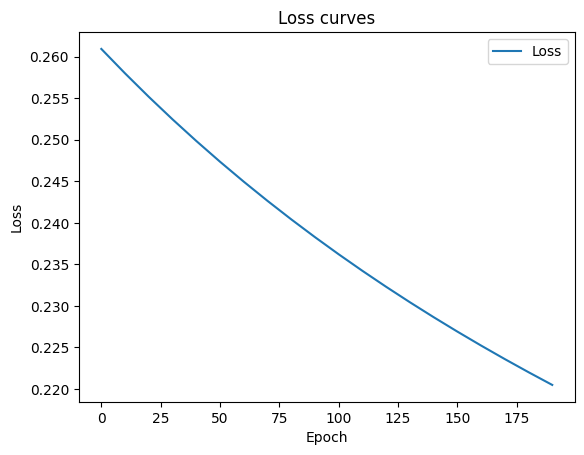

In [158]:
# Plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Loss")
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

In [159]:
model_Quadratic.state_dict()

OrderedDict([('c', tensor([-0.6322])),
             ('r', tensor([1.3299])),
             ('q', tensor([1.4050]))])

In [160]:
voltage.max(), current.max()

(tensor(408.6597), tensor(9.7283))

In [161]:
original_c = voltage.max() * model_Quadratic.c.item()
original_r = voltage.max() * model_Quadratic.r.item() / current.max()
original_q = voltage.max() * model_Quadratic.q.item() / (current.max() ** 2)
print(f"Original c: {original_c}")
print(f"Original r: {original_r}")
print(f"Original q: {original_q}")

Original c: -258.34710693359375
Original r: 55.8656005859375
Original q: 6.0666961669921875


In [162]:
model_Quadratic.c = nn.Parameter(torch.tensor([original_c], dtype=torch.float), requires_grad=False)
model_Quadratic.r = nn.Parameter(torch.tensor([original_r], dtype=torch.float), requires_grad=False)
model_Quadratic.q = nn.Parameter(torch.tensor([original_q], dtype=torch.float), requires_grad=False)

In [163]:
model_Quadratic.state_dict()

OrderedDict([('c', tensor([-258.3471])),
             ('r', tensor([55.8656])),
             ('q', tensor([6.0667]))])

In [164]:
with torch.inference_mode():
  y_preds_new = model_Quadratic(current)

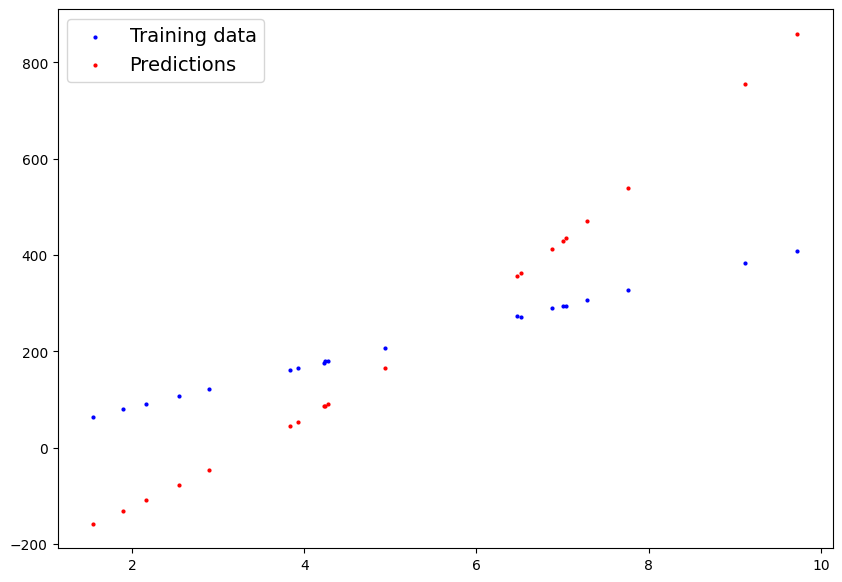

In [165]:
plot_predictions(predictions = y_preds_new)

### 2.1.2 Linear Model

In [167]:
from torch import nn

class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initalize model parameter
    self.c = nn.Parameter(torch.randn(1,
                                      requires_grad=True,
                                      dtype=torch.float))
    self.r = nn.Parameter(torch.randn(1,
                                      requires_grad=True,
                                      dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.c + self.r * x

In [168]:
model_Linear = LinearModel()

In [169]:
with torch.inference_mode():
  y_preds = model_Linear(current)

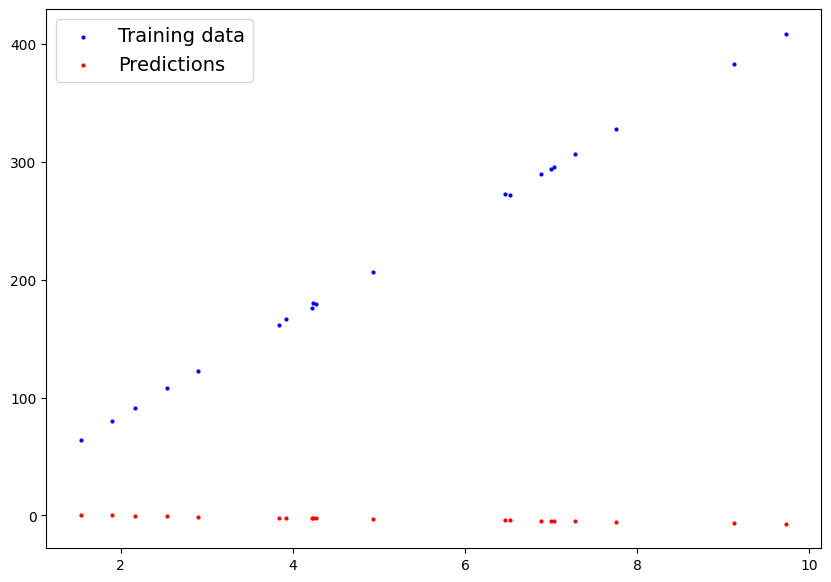

In [178]:
plot_predictions(predictions = y_preds)

In [179]:
# Setup a loss function
loss_fn = nn.MSELoss()

# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_Linear.parameters(),
                            lr = 0.001)

In [184]:
epochs = 200

epoch_count = []
loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  model_Linear.train()

  # 1. Forward pass
  y_pred = model_Linear(current)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, voltage)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backwardpropagation
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 6.632681846618652
Epoch: 10 | Loss: 6.596457481384277
Epoch: 20 | Loss: 6.560494422912598
Epoch: 30 | Loss: 6.5247650146484375
Epoch: 40 | Loss: 6.489232540130615
Epoch: 50 | Loss: 6.453971862792969
Epoch: 60 | Loss: 6.418957710266113
Epoch: 70 | Loss: 6.384134769439697
Epoch: 80 | Loss: 6.349575042724609
Epoch: 90 | Loss: 6.315258979797363
Epoch: 100 | Loss: 6.281130313873291
Epoch: 110 | Loss: 6.247237682342529
Epoch: 120 | Loss: 6.213587284088135
Epoch: 130 | Loss: 6.1801276206970215
Epoch: 140 | Loss: 6.146924018859863
Epoch: 150 | Loss: 6.113921165466309
Epoch: 160 | Loss: 6.081160068511963
Epoch: 170 | Loss: 6.048585414886475
Epoch: 180 | Loss: 6.016227722167969
Epoch: 190 | Loss: 5.9840989112854


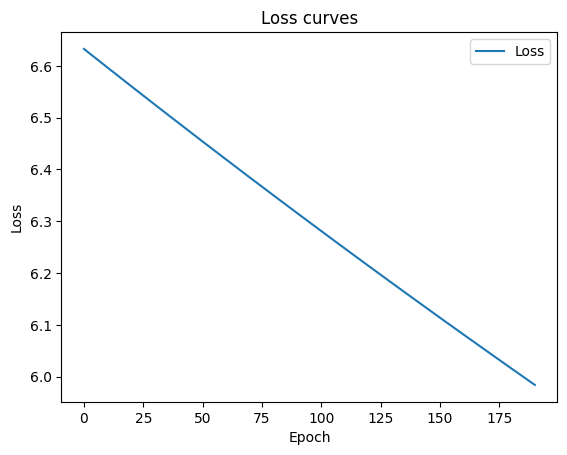

In [185]:
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Loss")
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

In [186]:
with torch.inference_mode():
  y_preds_new = model_Linear(current)

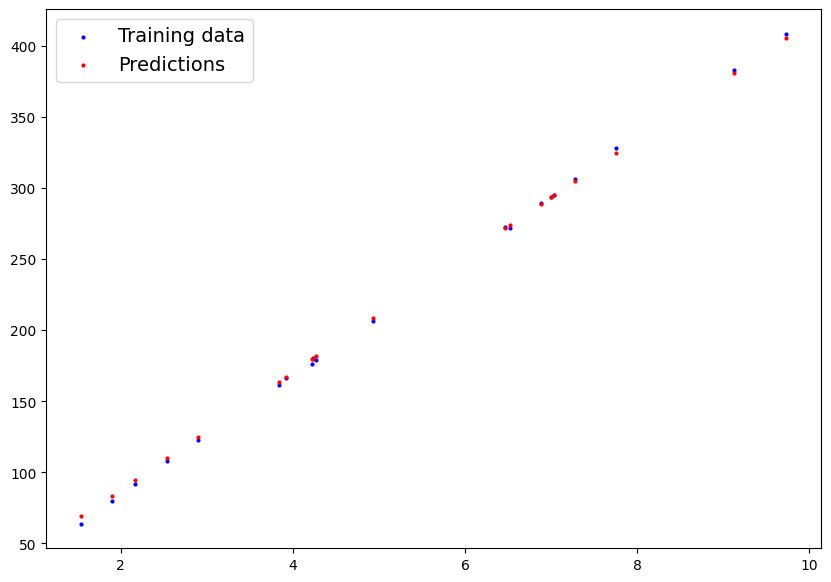

In [187]:
plot_predictions(predictions = y_preds_new)

In [188]:
model_Linear.state_dict()

OrderedDict([('c', tensor([5.8243])), ('r', tensor([41.1256]))])

### 2.1.3 Ohm's Law

In [278]:
from torch import nn

class OhmModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initalize model parameter
    self.r = nn.Parameter(torch.randn(1,
                                      requires_grad=True,
                                      dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.r * x

In [279]:
model_Ohm = OhmModel()

In [282]:
with torch.inference_mode():
  y_preds = model_Ohm(current)

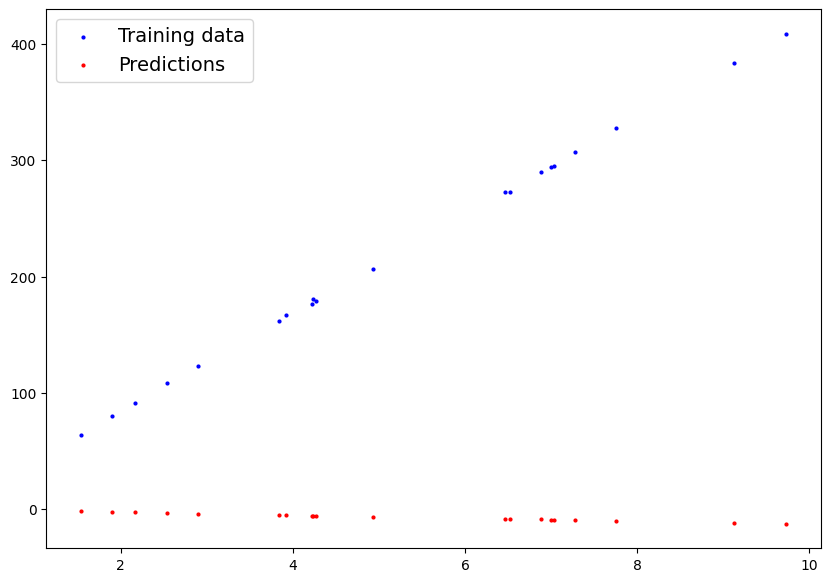

In [285]:
plot_predictions(predictions = y_preds)

In [286]:
# Setup a loss function
loss_fn = nn.MSELoss()

# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_Ohm.parameters(),
                            lr = 0.001)

In [289]:
epochs = 200

epoch_count = []
loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  model_Ohm.train()

  # 1. Forward pass
  y_pred = model_Ohm(current)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, voltage)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_Ohm.eval()

  # Print out what's happenin
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 1.2208412885665894
Epoch: 10 | Loss: 1.2208412885665894
Epoch: 20 | Loss: 1.2208412885665894
Epoch: 30 | Loss: 1.2208412885665894
Epoch: 40 | Loss: 1.2208412885665894
Epoch: 50 | Loss: 1.2208412885665894
Epoch: 60 | Loss: 1.2208412885665894
Epoch: 70 | Loss: 1.2208412885665894
Epoch: 80 | Loss: 1.2208412885665894
Epoch: 90 | Loss: 1.2208412885665894
Epoch: 100 | Loss: 1.2208412885665894
Epoch: 110 | Loss: 1.2208412885665894
Epoch: 120 | Loss: 1.2208412885665894
Epoch: 130 | Loss: 1.2208412885665894
Epoch: 140 | Loss: 1.2208412885665894
Epoch: 150 | Loss: 1.2208412885665894
Epoch: 160 | Loss: 1.2208412885665894
Epoch: 170 | Loss: 1.2208412885665894
Epoch: 180 | Loss: 1.2208412885665894
Epoch: 190 | Loss: 1.2208412885665894


In [290]:
with torch.inference_mode():
  y_preds_new = model_Ohm(current)

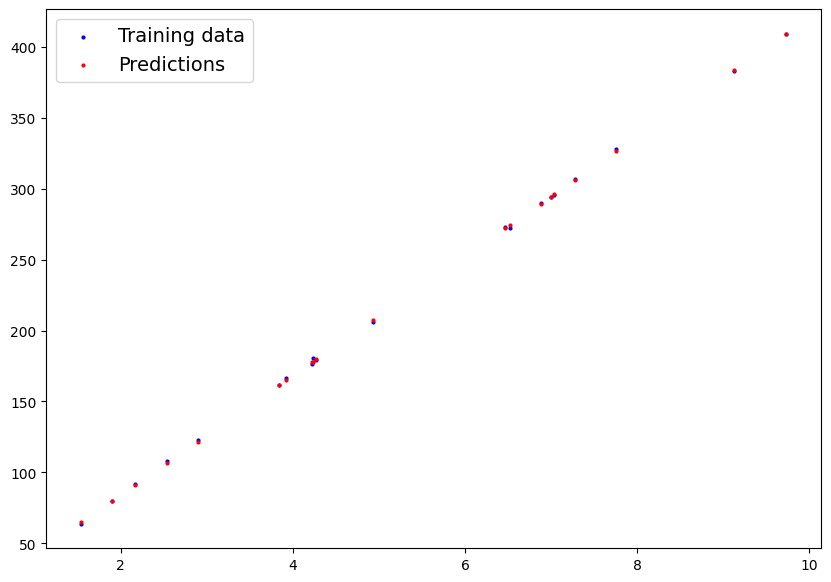

In [291]:
plot_predictions(predictions = y_preds_new)

In [292]:
model_Ohm.state_dict()

OrderedDict([('r', tensor([42.0567]))])

# 3. Wien's Approximation for the Temperature (bonus)

We will now use PyTorch to estimate the temperature of a black body. The energy emanated from a black body is given by Wien's approximation.

$$B_\lambda(T) = \frac{2 h c^2}{\lambda^5} \exp\left(-\frac{h c}{\lambda k T}\right)$$

That is, the amount of energy depends on the fifth power of the wavelength $\lambda$ and the temperature $T$ of the body. The latter ensures a cutoff beyond a temperature-characteristic peak. Let us define this and plot it.

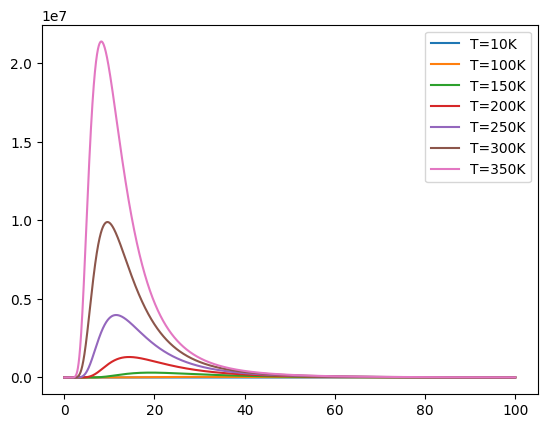

In [293]:
import torch
import matplotlib.pyplot as plt
# Lightspeed
c = 299792458
# Planck's constant
h = 6.62607004e-34
# Boltzmann constant
k = 1.38064852e-23
# Wavelength scale (nanometers)
lamscale = 1e-6
# Pulling out all powers of 10 upfront
p_out = 2 * h * c**2 / lamscale**5
p_in = (h / k) * (c/lamscale)

# Wien's law
def wien(lam, t):
    return (p_out / lam**5) * torch.exp(-p_in / (lam * t))

# Plot the radiance for a few different temperatures
lam = torch.arange(0,100,0.01)
for t in [10, 100, 150, 200, 250, 300, 350]:
    radiance = wien(lam, t)
    plt.plot(lam.numpy(), radiance.numpy(), label=('T=' + str(t) + 'K'))
plt.legend()
plt.show()

Next we assume that we are measuring some data. Of course, we need to pretend that we don't really know the temperature. But we measure the radiation at a few wavelengths.  

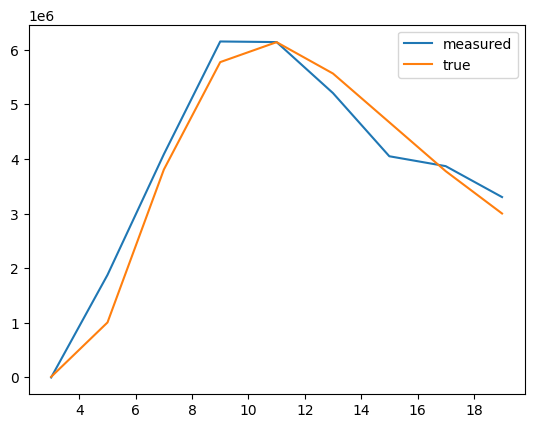

In [294]:
# real temperature is approximately 0C
realtemp = 273
# we observe at 3000nm up to 20,000nm wavelength
wavelengths = torch.arange(3,20,2)
# our infrared filters are pretty lousy ...
delta = torch.randn(len(wavelengths)) * 1

radiance = wien(wavelengths + delta,realtemp)
plt.plot(wavelengths.numpy(), radiance.numpy(), label='measured')
plt.plot(wavelengths.numpy(), wien(wavelengths, realtemp).numpy(), label='true')
plt.legend()
plt.show()

Use PyTorch to estimate the real temperature based on the variables `wavelengths` and `radiance`.

* You can use Wien's law implementation `wien(lam,t)` as your forward model.
* Use the loss function $l(y,y') = (\log y - \log y')^2$ to measure accuracy.

## 2.2 Answer

In [295]:
def plot_predictions(train_data = wavelengths,
                     train_labels = radiance,
                     predictions = None):
  '''
  Plots training data, test data and compares predictions.
  '''
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.plot(train_data, train_labels, c = "b", label = "Training data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.plot(train_data, predictions, c = "r", label = "Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

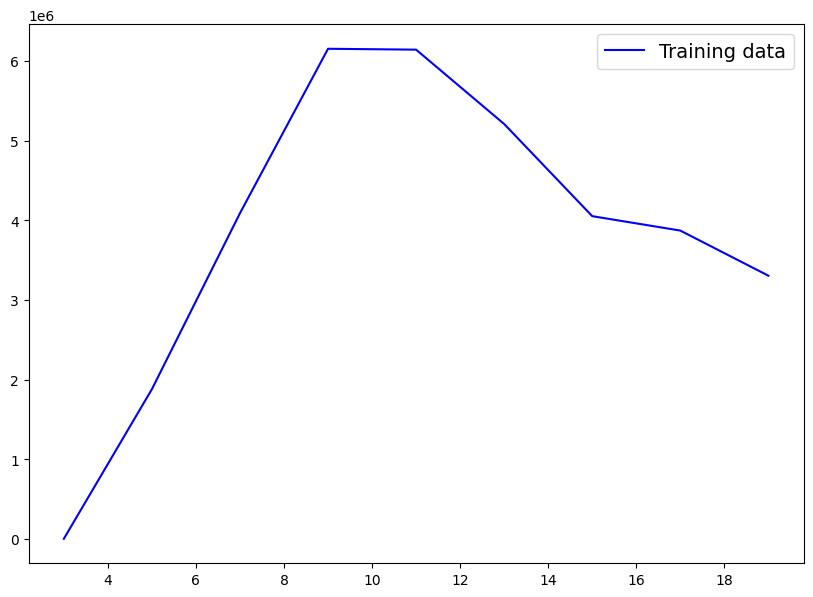

In [296]:
plot_predictions()

In [362]:
radiance_normalized = radiance / radiance.max()
radiance_normalized

tensor([5.6567e-07, 3.0531e-01, 6.6444e-01, 1.0000e+00, 9.9821e-01, 8.4647e-01,
        6.5839e-01, 6.2898e-01, 5.3692e-01])

In [425]:
from torch import nn

def wien(lam: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    # Ensure everything is on the same device and type
    device = lam.device
    dtype = lam.dtype

    p_out_tensor = torch.tensor(p_out, dtype=dtype, device=device)
    p_in_tensor  = torch.tensor(p_in, dtype=dtype, device=device)

    return (p_out_tensor / lam**5) * torch.exp(-p_in_tensor / (lam * t))

class WienModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Initalize model parameter
    self.t = nn.Parameter(torch.tensor([250.0], dtype = torch.float), requires_grad=True)

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return wien(x, self.t)

In [426]:
model_Wien = WienModel()

In [427]:
with torch.inference_mode():
  y_preds = model_Wien(wavelengths)

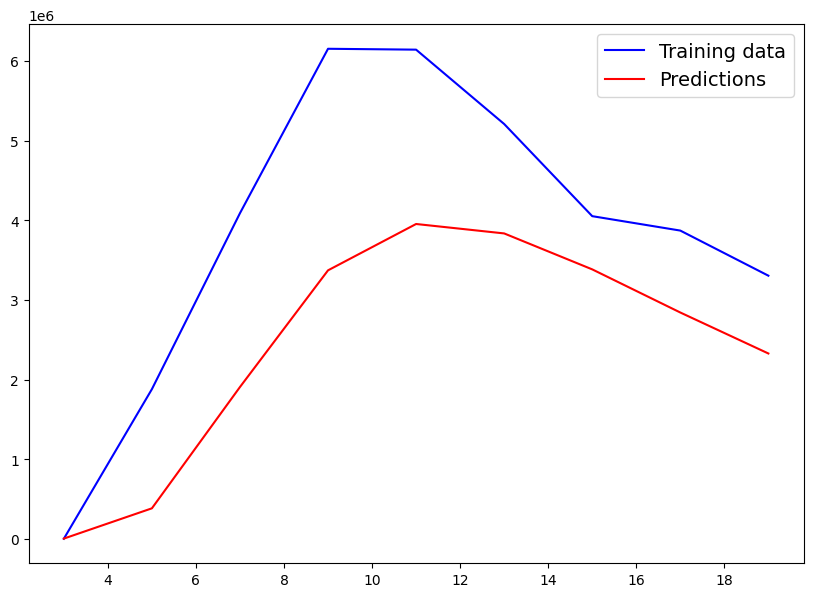

In [428]:
plot_predictions(predictions = y_preds)

In [429]:
from torch import nn
class LogMSELoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, y_pred, y_true):
    return torch.mean((torch.log(y_true) - torch.log(y_pred))**2)

In [430]:
# Setup a loss function
loss_fn = LogMSELoss()
#loss_fn = nn.MSELoss()


# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_Wien.parameters(),
                            lr = 0.1)

In [431]:
epochs = 200

# Track differnet values
epoch_count = []
loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  model_Wien.train()

  # 1. Forward pass
  y_pred = model_Wien(wavelengths)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, radiance)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_Wien.eval()

  # Print out what's happenin
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    print(f"Epoch: {epoch} | Loss: {loss}")
    print(f"Temperature: {model_Wien.t.item()}, Gradient: {model_Wien.t.grad}")

Epoch: 0 | Loss: 5.1236653327941895
Temperature: 249.99203491210938, Gradient: tensor([0.0796])
Epoch: 10 | Loss: 5.117340564727783
Temperature: 249.91250610351562, Gradient: tensor([0.0795])
Epoch: 20 | Loss: 5.111036777496338
Temperature: 249.8331298828125, Gradient: tensor([0.0793])
Epoch: 30 | Loss: 5.104755401611328
Temperature: 249.75389099121094, Gradient: tensor([0.0792])
Epoch: 40 | Loss: 5.098499298095703
Temperature: 249.6748046875, Gradient: tensor([0.0790])
Epoch: 50 | Loss: 5.0922675132751465
Temperature: 249.59585571289062, Gradient: tensor([0.0789])
Epoch: 60 | Loss: 5.086057662963867
Temperature: 249.51705932617188, Gradient: tensor([0.0787])
Epoch: 70 | Loss: 5.079866409301758
Temperature: 249.4384002685547, Gradient: tensor([0.0786])
Epoch: 80 | Loss: 5.07370138168335
Temperature: 249.35989379882812, Gradient: tensor([0.0784])
Epoch: 90 | Loss: 5.067558765411377
Temperature: 249.28152465820312, Gradient: tensor([0.0783])
Epoch: 100 | Loss: 5.061440467834473
Temperatu

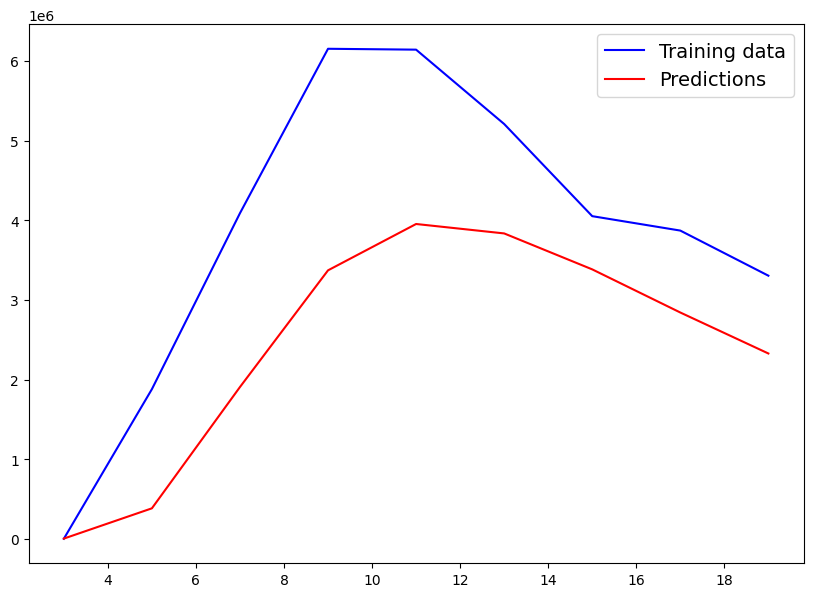

In [432]:
plot_predictions(predictions = y_preds)